# TODOS

- disaggregate by building size, dwell time

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-muted')
from matplotlib import cm
import seaborn as sns
import geopandas as gpd

from pyproj import Transformer
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import multiprocessing
from multiprocessing import Pool
from functools import partial
import numpy.random as npr
import matplotlib.dates as mdates
from itertools import product
import copy
import pickle
from tqdm import tqdm

import nomad.io.base as loader
import nomad.city_gen as cg
from nomad.city_gen import City, Building, Street
import nomad.traj_gen as tg
from nomad.traj_gen import Agent, Population
import nomad.stop_detection.ta_dbscan as DBSCAN
import nomad.stop_detection.lachesis as Lachesis
from nomad.constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS
from nomad.constants import FAST_STILL_PROBS, SLOW_STILL_PROBS, ALLOWED_BUILDINGS

from metrics import poi_map, identify_stop, prepare_diary, prepare_stop_table, cluster_metrics

import pdb

In [2]:
def plot_sparse_clusters(
    sparse_traj,
    labels,
    ax,
    full_traj=None,
    buffer=None,              # 0‒1 → pad bbox by (1+buffer); None → no limits
    cmap=cm.tab20c
):
    n_clusters = int(labels[labels >= 0].max() + 1) if (labels >= 0).any() else 0
    for cid in range(n_clusters):
        m = labels == cid
        ax.scatter(sparse_traj.x[m], sparse_traj.y[m],
                   s=80, color=cmap(cid / (n_clusters + 1)),
                   zorder=2)
    ax.scatter(sparse_traj.x, sparse_traj.y, s=6, color='black', zorder=2)
    if full_traj is not None:
        ax.plot(full_traj.x, full_traj.y, lw=1.2, color='blue', alpha=0.2, zorder=1)
        if buffer is not None:
            x0, x1 = full_traj.x.min(), full_traj.x.max()
            y0, y1 = full_traj.y.min(), full_traj.y.max()
            pad_x = (x1 - x0) * buffer / 2
            pad_y = (y1 - y0) * buffer / 2
            ax.set_xlim(x0 - pad_x, x1 + pad_x)
            ax.set_ylim(y0 - pad_y, y1 + pad_y)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    return ax

# Robustness to sparsity in pre-processing of human mobility data

**Francisco Jose Barreras**, Department of Computer and Information Science, University of Pennsylvania, Philadelphia, PA, USA

**Thomas Li**, Graduate School of Business, Stanford University, Palo Alto, CA, USA

**Duncan Watts**, Department of Computer and Information Science, University of Pennsylvania, Philadelphia, PA, USA

## Abstract

Pre-processing algorithms for human mobility data, such as stop detection, are vulnerable to errors when applied to sparse and bursty GPS datasets, but evaluating their robustness is difficult in the absence of ground truth. We address this challenge with a synthetic benchmarking framework that combines an agent-based generator of realistic trajectories—based on the Exploration and Preferential Return model (EPR)—with a sparse sampler that replicates the temporal structure of real GPS data. This setup allows controlled comparison of algorithm outputs against known ground-truth stops. We evaluate three stop-detection methods—ST-DBScan, Lachesis, and a grid-based algorithm—across varying levels of sparsity, burstiness, and parameterizations. Our analysis identifies failure modes such as stop merging, splitting, and missed stops, quantifies how often they arise under realistic movement patterns, and assesses how parameter tuning can mitigate them. We find that commonly used algorithms are not robust to levels of sparsity commonly found in commercial datasets, and that parameter choices critically affect outcomes. These experiments offer practical guidance for improving the reliability of GPS data processing in applied research.

## Introduction

Commercial GPS datasets have become central to human mobility research, powering applications in epidemiology, disaster response, transportation, urban planning, and behavioral science \cite{chang2021mobility, pepe2020covid, couture2021jue, moro2021mobility, gauvin2020gender, song2014prediction}. These datasets provide granular, high-frequency location signals from smartphones, but they are also sparse, bursty, and noisy—particularly when pings are collected opportunistically via apps or under privacy-preserving constraints. To extract useful signals from these raw data, researchers apply pre-processing algorithms to identify stops, trips, and frequently visited locations. However, many of these algorithms, including variants of DBScan \cite{birant2007st, ester1996density}, rule-based methods like Project Lachesis \cite{hariharan2004project}, and grid-based heuristics, were not designed with sparse or bursty signals in mind. Their performance in such settings is rarely tested, and robustness to signal degradation remains poorly understood.

Evaluating robustness in these settings is nontrivial. Real datasets typically lack ground truth: it is unknown whether a detected stop reflects a real event, or if a missed stop is due to noise, sparsity, or poor parameterization. Even synthetic benchmarks often assume uniformly sampled trajectories, which overlook the temporal irregularities that characterize real data. As a result, existing evaluations often prioritize computational efficiency over behavioral accuracy \cite{aslak2020infostop, chen2014t}, leaving open questions about how well these algorithms perform under the kinds of signal degradation found in commercial datasets.

We address this challenge by introducing a synthetic benchmarking framework designed to test the robustness of stop-detection algorithms under realistic conditions. Our framework builds on the Garden City mobility model \cite{2412.00913v1}, which uses an Exploration and Preferential Return (EPR) model to simulate human mobility patterns at both macro and micro scales. Agents generate full, minute-level “ground-truth” trajectories as they move through a synthetic city composed of homes, workplaces, and public locations. These trajectories are then sparsified using a self-exciting point process that captures the bursty nature of GPS pings, and measurement noise is added to mimic GPS error. These sparse trajectories, alongside their ground-truth counterparts, allow us to quantify the accuracy and robustness of stop-detection algorithms used in the human mobility literature.

Using this framework, we evaluate the robustness of three stop-detection algorithms—ST-DBScan \cite{birant2007st}, Lachesis \cite{hariharan2004project}, and a simple grid-based method—by comparing their outputs to the ground-truth mobility diaries of the simulated agents. Our analysis proceeds in three parts. First, we characterize the failure modes of these algorithms using controlled synthetic trajectories, identifying phenomena such as stop merging (over-clustering), stop splitting (under-clustering), and omission of stops altogether. Second, we test whether these failure modes persist under more realistic mobility traces, and analyze their frequency and correlation with features of the signal such as ping density, burst structure, and location size. Finally, we show that careful parameter tuning can mitigate some—but not all—of these issues, and provide practical guidance on how to select parameters in the presence of sparse and noisy data.

Our results indicate that most stop-detection algorithms are not robust to realistic forms of sparsity, and that failure rates depend strongly on the temporal structure of the data—not just its average sampling rate. These findings underscore the need for more principled benchmarking and parameter selection in GPS data processing pipelines, especially for applications where downstream metrics are sensitive to stop detection.

## Possible errors in stop detection

We focus on errors of two types. Clustering pings that should not be clustered together, in particular, merging of two stops that occur in nearby buildings. This should occur more often when the algorithm parameters are coarser.
The other problem is failure to cluster pings that correspond to the same stop, this is a problem when the movement is to broad and the parameters are too fine, but also when there are long gaps in the data. Thus, we anticipate the error to be related to area and dwell times. We call these "missed stops" and "splitting"

**Ad-hoc trajectory 1**: 4 one-hour-long visits to nearby buildings.

$\varepsilon$: Stop-detection distance thresholds ($\varepsilon$) larger than the distance between two buildings guarantee merging. We experiment with $\varepsilon = 12m$ for DBScan, and $\varepsilon = 30m$ for Lachesis, to cover a non-trivial regime.

![Ad-hoc Trajectory 1](./ad-hoc-traj-1.png)

**Ad-hoc trajectory 2**:  5 visits to separate buildings, with varying areas and dwell times.

$\Delta T$: Stop-detection max allowed gap of 90 minutes is common and allows for splitting when dwelling for a long time. We experiment with $\varepsilon = 18m$ for DBSCan, and $\varepsilon = 30m$ for Lachesis, to allow some spatial splitting.

![Ad-hoc Trajectory 2](./ad-hoc-traj-2.png)

Initialization of city and population

In [3]:
city_geojson = gpd.read_file('../garden_city.geojson')
city = cg.load('../garden-city.pkl')

## Experiment 1

Demonstrate merging: four neighboring small stops.

In [4]:
start_time = pd.date_range(start='2024-06-01 00:00-04:00', periods=4, freq='60min')
tz_offset = loader._offset_seconds_from_ts(start_time[0])
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*4  # in minutes
location = ['h-x13-y11'] * 1 + ['h-x13-y9'] * 1 + ['w-x18-y10'] * 1 + ['w-x18-y8'] * 1

destination = pd.DataFrame(
    {"datetime":start_time,
     "unix_timestamp":unix_timestamp,
     "duration":duration,
     "location":location}
     )
destination = tg.condense_destinations(destination)

In [5]:
traj_cols = {'user_id':'identifier',
             'x':'x',
             'y':'y',
             'timestamp':'unix_timestamp'}

Example plot

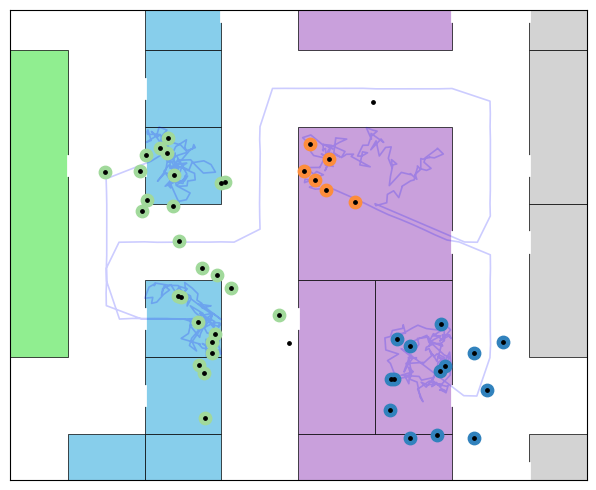

CPU times: total: 500 ms
Wall time: 509 ms


In [14]:
%%time
Charlie = Agent(identifier="Charlie",
                home='h-x13-y11',
                workplace='w-x18-y8',
                city=city)

Charlie.generate_trajectory(destination_diary=destination, seed=100, dt=0.05)
Charlie.sample_trajectory(beta_start=None,
                          beta_durations=None, # <<< default is None, so it could be removed
                          beta_ping = 4,
                          seed=1,
                          ha=13/15,
                          replace_sparse_traj=True,
                          deduplicate=True)

dbscan_out = DBSCAN._temporal_dbscan_labels(data=Charlie.sparse_traj,
                                            time_thresh=600,
                                            dist_thresh=0.8,
                                            min_pts=3,
                                            dur_min=5,
                                            traj_cols=traj_cols)

lachesis_out = Lachesis._lachesis_labels(data=Charlie.sparse_traj,
                                         dt_max=600,
                                         delta_roam=2,
                                         dur_min=5,
                                         traj_cols=traj_cols)

fig, ax = plt.subplots(figsize=(9, 5))
city.plot_city(ax, doors=True, address=False, zorder=0)

plot_sparse_clusters(Charlie.sparse_traj, dbscan_out.cluster, ax,
                     full_traj=Charlie.trajectory, buffer=0.5)

plt.savefig("exp1-merging-dbscan.png")
plt.show()

In [ ]:
beta_start = None
beta_dur = None
beta_ping = np.arange(2, 12.5, 0.5)

dbscan_params = [(600, 0.8, 3)]
lachesis_params = [(5, 600, 2)]  # dur_min, dt_max, and delta_roam

# pass a dict with **dbscan_params instead
dbscan_params = [dict(time_thresh=600, dist_thresh=0.8, min_pts=3, dur_min=5)]
lachesis_params = [dict(dur_min=5, dt_max=600, delta_roam=2)] 

N = 1000

In [ ]:
%%time

# Run with parallelization

# TODO:
# We should now follow the most up to date pipeline as in hdbscan-branch
# (1) produce cluster labels (Series with same index as data) 
# (2) join cluster labels to data and use visit_attribution with "majority" mode to get building_id (Series)
# (3) join building_id with data_with_clusters and then groupby.apply summarize_stop, with passthrough col "building id"
# (4) obtain overlapping visits with ground truth using contact_estimation.overlapping_visits
# (5) compute error metrics, also in contact_estimation

def process_seed(seed, beta_ping, dbscan_params, beta_start, beta_dur, city, destination):
    metrics_out = []

    agent = Agent(
        identifier="Charlie",
        home='h-x13-y11',
        workplace='w-x18-y8',
        city=city)
    
    agent.reset_trajectory()
    agent.generate_trajectory(destination_diary=destination, dt=1, seed=seed)

    for bp in beta_ping:
        agent.sample_trajectory(beta_start, beta_dur, bp, seed=seed, ha=3/4, replace_sparse_traj=True)

        # Run DBScan
        for j, dbscan_param in enumerate(dbscan_params):
            dbscan_out = DBSCAN._temporal_dbscan_labels(agent.sparse_traj, **dbscan_param, traj_cols)
            dbscan_out.index = dbscan_out.index.map(lambda x: int(x.timestamp()))
            stop_table = DBSCAN.temporal_dbscan(agent.sparse_traj, **dbscan_param, traj_cols, complete_output=False)
            stop_table = identify_stop(dbscan_out.cluster, agent.sparse_traj, stop_table, city_geojson, method='mode')
            _, metrics = cluster_metrics(stop_table, agent, city)

            metrics_out.append([
                float(bp), seed, f'dbscan (eps=12)', 
                metrics['Stops Merged'], metrics['Prop Stops Merged'],
                metrics['Split'], metrics['Recall'], metrics['Precision']
            ])
        
        # Run Lachesis
        for j, lachesis_param in enumerate(lachesis_params):
            lachesis_out = Lachesis._lachesis_labels(agent.sparse_traj, **lachesis_param, traj_cols)
            lachesis_out.index = lachesis_out.index.map(lambda x: int(x.timestamp()))
            stop_table = Lachesis.lachesis(agent.sparse_traj, **lachesis_param, traj_cols, complete_output=False)
            stop_table.rename(columns={'datetime':'start_time'}, inplace=True)
            stop_table = identify_stop(lachesis_out, agent.sparse_traj, stop_table, city_geojson, method='mode')
            _, metrics = cluster_metrics(stop_table, agent, city)

            metrics_out.append([
                float(bp), seed, f'lachesis (eps=30)', 
                metrics['Stops Merged'], metrics['Prop Stops Merged'],
                metrics['Split'], metrics['Recall'], metrics['Precision']
            ])

    return metrics_out
    
def parallelize_work(beta_ping, N, dbscan_params, beta_start, beta_dur, city, destination):
    results = []

    with ProcessPoolExecutor() as executor:
        tasks = [
            executor.submit(
                process_seed,
                seed,
                beta_ping,
                dbscan_params,
                beta_start,
                beta_dur,
                city,
                destination
            )
            for seed in range(N)
        ]
        total_tasks = len(tasks)
        with tqdm(total=total_tasks, desc="Processing tasks") as pbar:
            for future in concurrent.futures.as_completed(tasks):
                try:
                    task_metrics = future.result()
                    results.extend(task_metrics)
                except Exception as e:
                    print(f"Task failed: {e}")
                finally:
                    pbar.update(1)

    return results

local_metrics = parallelize_work(beta_ping, N, dbscan_params, beta_start, beta_dur, city, destination)
local_metrics = pd.DataFrame(list(local_metrics), 
                             columns=['beta_ping', 'seed', 'algorithm', 'merged', 'prop_merged', 'split', 'recall', 'precision'])
local_metrics['f1_score'] = 2 * (local_metrics['precision'] * local_metrics['recall']) / (local_metrics['precision'] + local_metrics['recall'])
local_metrics.to_pickle("local_metrics_exp1.pkl")

In [ ]:
with open("local_metrics_exp1.pkl", "rb") as f:
    local_metrics = pickle.load(f)

In [ ]:
local_metrics_avg = local_metrics.groupby(['beta_ping', 'algorithm'])['prop_merged'].mean().reset_index()
pivoted = local_metrics_avg.pivot(index='beta_ping', columns='algorithm', values='prop_merged')

ax = pivoted.plot(
    kind='line',
    figsize=(8, 6)
)

ax.set_title('Stops Exhibiting Merging / (True Stops - 1)', fontsize=16)
ax.set_xlabel('beta_p : Average Time Between Pings (in Burst)', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
plt.savefig("merging.png")
plt.savefig("merging.svg")

plt.show()

## Experiment 2

Demonstrate splitting: 5 stops of varying areas and dwell times

In [ ]:
tz = ZoneInfo("America/New_York")
start_time = pd.date_range(start='2024-06-01 03:00', periods=18, freq='60min', tz=tz)
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*18  # in minutes
location = ['h-x13-y6'] * 7 + ['r-x15-y0'] * 1 + ['w-x18-y13'] * 6 + ['r-x18-y5'] * 1 + ['p-x13-y11'] * 3

destination = pd.DataFrame(
    {"datetime":start_time,
     "unix_timestamp":unix_timestamp,
     "duration":duration,
     "location":location}
     )
destination = tg.condense_destinations(destination)

traj_cols = {'user_id':'identifier',
             'latitude':'x',
             'longitude':'y',
             'datetime':'datetime'}

In [ ]:
destination.location

Example plot

In [ ]:
Charlie = Agent(identifier="Charlie",
                home='h-x13-y11',
                workplace='w-x18-y8',
                city=city)

Charlie.generate_trajectory(destination_diary=destination, dt=1, seed=300)
Charlie.sample_trajectory(*(20, 45, 10), seed=300, replace_sparse_traj=True)

dbscan_param = (90, 2, 2)
dbscan_out = DBSCAN._temporal_dbscan_labels(Charlie.sparse_traj, *dbscan_param, traj_cols)
dbscan_out.index = dbscan_out.index.map(lambda x: int(x.timestamp()))
stop_table = DBSCAN.temporal_dbscan(Charlie.sparse_traj, *dbscan_param, traj_cols, complete_output=False)
stop_table = identify_stop(dbscan_out.cluster, Charlie.sparse_traj, stop_table, city_geojson, method='centroid')
metrics_df, metrics = cluster_metrics(stop_table, Charlie, city)

# lachesis_param = (20, 75, 2)
# lachesis_out = Lachesis._lachesis_labels(Charlie.sparse_traj, *lachesis_param, traj_cols)
# lachesis_out.index = lachesis_out.index.map(lambda x: int(x.timestamp()))  
# stop_table = Lachesis.lachesis(Charlie.sparse_traj, *lachesis_param, traj_cols, complete_output=False)
# stop_table.rename(columns={'datetime':'start_time'}, inplace=True)
# stop_table = identify_stop(lachesis_out, Charlie.sparse_traj, stop_table, city_geojson, method='mode')

fig, ax = plt.subplots(figsize=(9, 5))
city.plot_city(ax, doors=True, address=False, zorder=0)

plot_sparse_clusters(Charlie.sparse_traj, dbscan_out.cluster, ax,
                     full_traj=Charlie.trajectory, buffer=0.25)

# plt.savefig("exp2-splitting-dbscan.png")
plt.show()

In [ ]:
print(metrics_df)

In [ ]:
diary = Charlie.diary.dropna().copy()
sparse_traj = Charlie.sparse_traj.copy()

location_mapping = {loc: idx for idx, loc in enumerate(diary['location'].unique())}
diary['location_num'] = diary['location'].map(location_mapping)
stop_table['location_num'] = stop_table['location'].map(location_mapping)

# Create the plot
plt.figure(figsize=(14, 2))

# Plot stop_table
for idx, row in stop_table.iterrows():
    start_time = row['start_time']
    end_time = start_time + pd.Timedelta(minutes=row['duration'])
    plt.plot([start_time, end_time], [row['location_num'], row['location_num']], color='blue', label='Lachesis' if idx == 0 else "", zorder=3)

# Plot diary data with shaded rectangles
for idx, row in diary.iterrows():
    start_time = row['datetime']
    end_time = start_time + pd.Timedelta(minutes=row['duration'])
    plt.fill_between([start_time, end_time], [row['location_num'] - 0.2, row['location_num'] - 0.2], [row['location_num'] + 0.2, row['location_num'] + 0.2], color='lightgrey', alpha=0.5, label='Ground Truth' if idx == 0 else "", zorder=1)
    pings = sparse_traj[(sparse_traj['datetime'] >= start_time) & (sparse_traj['datetime'] <= end_time)]
    pings = pings['datetime'].to_frame()
    pings['location_num'] = row['location_num']
    plt.plot(pings['datetime'], pings['location_num'], '|', markersize=8, color='black', alpha=0.5, zorder=2)

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.xlabel('')
plt.ylabel('Building', fontsize=14)
plt.yticks(ticks=list(location_mapping.values()), labels=list(location_mapping.keys()))
plt.legend()

# plt.savefig('stops_temporal_lachesis.svg')
plt.show()

In [ ]:
beta_start = np.arange(10, 200, 10)
beta_dur = 45
beta_ping = 10

dbscan_params = [(90, 1.2, 2)]  # time_thresh, dist_thresh, min_pts
lachesis_params = [(5, 90, 2)]  # dur_min, dt_max, and delta_roam

N = 1000

In [ ]:
%%time

# Run with parallelization
metrics_by_stops_dbscan = {}
metrics_by_stops_lachesis = {}

def process_seed(seed, beta_ping, dbscan_params, beta_start, beta_dur, city, destination):
    metrics_out = []

    agent = Agent(
        identifier="Charlie",
        home='h-x13-y11',
        workplace='w-x18-y8',
        city=city)
    
    agent.reset_trajectory()
    agent.generate_trajectory(destination_diary=destination, dt=1, seed=seed)

    for bs in beta_start:
        agent.sample_trajectory(bs, beta_dur, beta_ping, seed=seed, ha=3/4, replace_sparse_traj=True)

        # Run DBScan
        for j, dbscan_param in enumerate(dbscan_params):
            dbscan_out = DBSCAN._temporal_dbscan_labels(agent.sparse_traj, *dbscan_param, traj_cols)
            dbscan_out.index = dbscan_out.index.map(lambda x: int(x.timestamp()))
            stop_table = DBSCAN.temporal_dbscan(agent.sparse_traj, *dbscan_param, traj_cols, complete_output=False)
            stop_table = identify_stop(dbscan_out.cluster, agent.sparse_traj, stop_table, city_geojson, method='mode')
            metrics_df, metrics = cluster_metrics(stop_table, agent, city)

            metrics_out.append([
                float(bs), seed, f'dbscan (eps=12)', 
                metrics['Stops Merged'], metrics['Prop Stops Merged'],
                metrics['Split'], metrics['Prop Split'], metrics['Missed']/5, 
                metrics['Recall'], metrics['Precision']
            ])

        # Run Lachesis
        for j, lachesis_param in enumerate(lachesis_params):
            lachesis_out = Lachesis._lachesis_labels(agent.sparse_traj, *lachesis_param, traj_cols)
            lachesis_out.index = lachesis_out.index.map(lambda x: int(x.timestamp()))
            stop_table = Lachesis.lachesis(agent.sparse_traj, *lachesis_param, traj_cols, complete_output=False)
            stop_table.rename(columns={'datetime':'start_time'}, inplace=True)
            stop_table = identify_stop(lachesis_out, agent.sparse_traj, stop_table, city_geojson, method='mode')
            metrics_df, metrics = cluster_metrics(stop_table, agent, city)

            metrics_out.append([
                float(bs), seed, f'lachesis (eps=30)', 
                metrics['Stops Merged'], metrics['Prop Stops Merged'],
                metrics['Split'], metrics['Prop Split'], metrics['Missed']/5, 
                metrics['Recall'], metrics['Precision']
            ])

    return metrics_out
    
def parallelize_work(beta_ping, N, dbscan_params, beta_start, beta_dur, city, destination):
    results = []

    with ProcessPoolExecutor() as executor:
        tasks = [
            executor.submit(
                process_seed,
                seed,
                beta_ping,
                dbscan_params,
                beta_start,
                beta_dur,
                city,
                destination
            )
            for seed in range(N)
        ]
        total_tasks = len(tasks)
        with tqdm(total=total_tasks, desc="Processing tasks") as pbar:
            for future in concurrent.futures.as_completed(tasks):
                try:
                    task_metrics = future.result()
                    results.extend(task_metrics)
                except Exception as e:
                    print(f"Task failed: {e}")
                finally:
                    pbar.update(1)

    return results

local_metrics = parallelize_work(beta_ping, N, dbscan_params, beta_start, beta_dur, city, destination)
local_metrics = pd.DataFrame(list(local_metrics), 
                             columns=['beta_start', 'seed', 'algorithm', 'merged', 'prop_merged', 
                                      'split', 'prop_split', 'missed', 'recall', 'precision'])
local_metrics['f1_score'] = 2 * (local_metrics['precision'] * local_metrics['recall']) / (local_metrics['precision'] + local_metrics['recall'])
local_metrics.to_pickle("local_metrics_exp2.pkl")

In [ ]:
local_metrics_avg = local_metrics.groupby(['beta_start', 'algorithm'])[['prop_split', 'missed']].mean().reset_index()
local_metrics_avg['both'] = local_metrics_avg['prop_split'] + local_metrics_avg['missed']
local_metrics_dbscan = local_metrics_avg[local_metrics_avg.algorithm == 'dbscan (eps=12)']
local_metrics_lachesis = local_metrics_avg[local_metrics_avg.algorithm == 'lachesis (eps=30)']

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# Plot for DBSCAN
axes[0].plot(local_metrics_dbscan['beta_start'], local_metrics_dbscan['prop_split'], label='Splitting')
axes[0].plot(local_metrics_dbscan['beta_start'], local_metrics_dbscan['missed'], label='Missing')
axes[0].plot(local_metrics_dbscan['beta_start'], local_metrics_dbscan['both'], 
             label='Splitting or Missing', linestyle='--', color='gray')
axes[0].set_title('DBSCAN: Stops Split and Missed')
axes[0].set_xlabel('beta_start : mean minutes between bursts', fontsize=12)
axes[0].set_ylabel('Proportion of Stops', fontsize=12)
axes[0].legend()
axes[0].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

# Plot for Lachesis
axes[1].plot(local_metrics_lachesis['beta_start'], local_metrics_lachesis['prop_split'], label='Splitting')
axes[1].plot(local_metrics_lachesis['beta_start'], local_metrics_lachesis['missed'], label='Missing')
axes[1].plot(local_metrics_lachesis['beta_start'], local_metrics_lachesis['both'], 
             label='Splitting or Missing', linestyle='--', color='gray')
axes[1].set_title('Lachesis: Stops Split and Missed')
axes[1].set_xlabel('beta_start : mean minutes between bursts', fontsize=12)
axes[1].legend()
axes[1].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
plt.savefig("split-missed-comparison.png")
plt.show()

![title](./example-of-problems.png)

## Methodology

- We explain garden city and how we produced ground truth, heavily referencing the Arxiv version
- We divide in three sections after that
- Possible problems in stop detection
- Are these problems present in real (global) trajectories? + covariates
- Can the parameterizations address these issues?

There are regimes in which certain problems disappear.
- E.g. going from extremely complete signals to very complete signals, might not make a difference in terms of quality---they are both good enough. This analysis could be visualized in a plot with q in the x-axis, showing that for high q and very low q things break down. 
- E.g. a very bad parameterization of DBScan for retail, might obscure a small effect of beta ping on retail. 
- Some problems might mostly affect users that explore a lot (this is application-relevant). 
- Maybe the conclusion is that you need a hierarchical DBScan

We show problems. Can we THEN show solutions? Then maybe we can hint at solutions while describing problems. 

## Global problems

Related to the intensity and clustering of the bursts. It can affect if stops are missed (recall), it can also mess with accuracy by building type (typically long/short dwells).

- Missingness is more severe for home and work compared to retail and park. Maybe a ratio statistic alongside the magnitude decreases. Pick a "reasonable" DBScan (based on recall). Parameters of a typical user in a typical dataset (avoid a regime where nothing/everything works). 
- Obvious plot is you have less signal (gray rectangles) then you miss more stops/time-at-right-stop overall. Show regimes? Specially for exploration-prone users? + nuance.

## Parameterization problems

You can truly choose the wrong parameters, and you might want to incorporate user signal parameters and building areas, and whatnot. Quality of algorithms and how to choose. x-axis is parameter of DBScan and y-axis is quality of clusters.
- What would you do with a complete and regular signal? Maybe a "reasonable" DBScan would fail miserably and Lachesis would succeed? min_pts would save the day? 
- Time parameter ranges from 1 hour to 16 hours. Long-dwell "bridging" of huge gaps would increase (obviously) but, the nuance is overestimating time at work or at home. Absolute vs Relative. 
- Epsilon affects splitting and merging. Pick a "default and reasonable" beta_ping and change epsilon. 

Initialization of city and population

In [ ]:
city_geojson = gpd.read_file('../garden_city.geojson')
city = cg.load('../garden-city.pkl')

N = 10
population = Population(city)
population.generate_agents(N = N,
                           start_time = pd.Timestamp('2024-01-01 07:00', tz='America/New_York'),
                           seed = 100)

for i, agent_id in enumerate(population.roster):
    agent = population.roster[agent_id]
    population.generate_trajectory(agent,
                                   T = pd.Timestamp('2024-01-08 07:00', tz='America/New_York'),
                                   seed=i)

## Simulate 1000 Agents*

Initialize 1000 agents and generate one week of ground-truth trajectory data for each.

USE SYNTHETIC DATA!!

In [ ]:
N = 10
population_1000 = Population(city)
population_1000.generate_agents(N = N, 
                                start_time = datetime(2024, 1, 1, hour=7, minute=0),
                                seed = 100)

for i, agent_id in enumerate(population_1000.roster):
    agent = population_1000.roster[agent_id]
    population_1000.generate_trajectory(agent, 
                                        T = datetime(2024, 1, 8, hour=7, minute=0),
                                        seed=i)

In [ ]:
%%time

N = 10

population_1000 = Population(city)
population_1000.generate_agents(N = N, 
                                start_time = datetime(2024, 1, 1, hour=7, minute=0),
                                seed = 100)

def generate_agent_trajectory(agent_id, shared_roster, seed):
    agent = shared_roster[agent_id]
    population_1000.generate_trajectory(agent, 
                                   T = datetime(2024, 1, 8, hour=7, minute=0),
                                   seed=seed)
    shared_roster[agent_id] = agent

manager = multiprocessing.Manager()
shared_roster = manager.dict(population_1000.roster)

with ProcessPoolExecutor() as executor:
    futures = [
        executor.submit(generate_agent_trajectory, agent_id, shared_roster, i)
        for i, agent_id in enumerate(shared_roster)
    ]

    with tqdm(total=len(futures), desc="Generating agent trajectories") as pbar:
        for future in concurrent.futures.as_completed(futures):
            try:
                future.result()
                pbar.update(1)
            except Exception as e:
                print(f"Task failed with exception: {e}")
                pbar.update(1)

population_1000.roster = dict(shared_roster)

## Global Problems

Related to the intensity and clustering of the bursts. It can affect if stops are missed (recall), it can also mess with accuracy by building type (typically long/short dwells).

- Missingness is more severe for home and work compared to retail and park. Maybe a ratio statistic alongside the magnitude decreases. Pick a "reasonable" DBScan (based on recall). Parameters of a typical user in a typical dataset (avoid a regime where nothing/everything works). 
- Obvious plot is you have less signal (gray rectangles) then you miss more stops/time-at-right-stop overall. Show regimes? Specially for exploration-prone users? + nuance.

### EPR, recall and precision*

fix the agent and their ground-truth trajectory. vary sampling parameters. 

In [ ]:
beta_starts = range(120, 1600, 40)
beta_durs = range(30, 400, 10)
beta_ping = 10
sparsity_params = [(start, dur, beta_ping) for start, dur in zip(beta_starts, beta_durs)]

dbscan_params = [(120, 0.5, 4), (180, 2, 2)] 
lachesis_params = [(5, 120, 3)] # [(5, 120, 2), (5, 120, 1.5)] #dur_min, dt_max, and delta_roam

N = 1  # how many times to run each agent-sparsity pair

traj_cols = {'user_id':'identifier',
             'latitude':'x',
             'longitude':'y',
             'datetime':'datetime'}

In [ ]:
%%time

# run without parallelization

agent = population_1000.roster['quirky_chebyshev']

def process_sample(sparsity_param, seed, agent, city, shared_metrics):
    agent.sample_traj_hier_nhpp(*sparsity_param, seed=seed, ha=3/4, replace_sparse_traj=True)
    qstat = q_stat(agent)

    # Run DBScan
    for j, dbscan_param in enumerate(dbscan_params):
        dbscan_out = sd._temporal_dbscan_labels(agent.sparse_traj, *dbscan_param, traj_cols)
        stop_table = sd.temporal_dbscan(agent.sparse_traj, *dbscan_param, traj_cols, complete_output=False)
        stop_table = identify_stop(dbscan_out, agent.sparse_traj, stop_table, city, method='mode')
        _, metrics = cluster_metrics(stop_table, agent)
        merged = metrics['Stops Merged']
        split = metrics['Split']
        recall = metrics['Recall']
        precision = metrics['Precision']
        # Save metrics
        shared_metrics.append([qstat, seed, agent.identifier, ['dbscan', 'dbscan2'][j], 
                               merged, split, recall, precision])

    # Run Lachesis
    for j, lachesis_param in enumerate(lachesis_params):
        lachesis_out = sd._lachesis_labels(agent.sparse_traj, *lachesis_param, traj_cols)
        stop_table = sd.lachesis(agent.sparse_traj, *lachesis_param, traj_cols, complete_output=False)
        stop_table = identify_stop(lachesis_out, agent.sparse_traj, stop_table, city, method='mode')
        _, metrics = cluster_metrics(stop_table, agent)
        merged = metrics['Stops Merged']
        split = metrics['Split']
        recall = metrics['Recall']
        precision = metrics['Precision']
        # Save metrics
        shared_metrics.append([qstat, seed, agent.identifier, ['lachesis', 'lachesis2'][j], 
                               merged, split, recall, precision])

def sequential_work(sparsity_params, N, city):
    shared_metrics = []

    total_tasks = N*len(sparsity_params)
    task_counter = 0

    with tqdm(total=total_tasks, desc="Processing tasks") as pbar:
        for sparsity_param in sparsity_params:
            for seed in range(N):
                process_sample(sparsity_param, seed, Chebyshev, city, shared_metrics)
                task_counter += 1
                pbar.update(1)

    return shared_metrics

epr_metrics = sequential_work(sparsity_params, N, city)
epr_metrics = pd.DataFrame(
    epr_metrics,
    columns=['q', 'seed', 'agent', 'algorithm', 'merged', 'split', 'recall', 'precision']
)

In [ ]:
%%time

# Run with parallelization

def process_sample(sparsity_param, seed, agent_id, city, shared_metrics):
    agent = population_1000.roster[agent_id]
    agent.sample_traj_hier_nhpp(*sparsity_param, seed=seed, ha=3/4, replace_sparse_traj=True)
    qstat = q_stat(agent)

    # Run DBScan
    for j, dbscan_param in enumerate(dbscan_params):
        dbscan_out = sd._temporal_dbscan_labels(agent.sparse_traj, *dbscan_param, traj_cols)
        stop_table = sd.temporal_dbscan(agent.sparse_traj, *dbscan_param, traj_cols, complete_output=False)
        stop_table = identify_stop(dbscan_out, agent.sparse_traj, stop_table, city, method='mode')
        _, metrics = cluster_metrics(stop_table, agent)
        merged = metrics['Stops Merged']
        prop_merged = metrics['Prop Stops Merged']
        split = metrics['Split']
        recall = metrics['Recall']
        precision = metrics['Precision']
        # Save metrics
        shared_metrics.append([qstat, seed, agent_id, ['dbscan-fine', 'dbscan-coarse'][j], 
                               merged, prop_merged, split, recall, precision])

    # Run Lachesis
    for j, lachesis_param in enumerate(lachesis_params):
        lachesis_out = sd._lachesis_labels(agent.sparse_traj, *lachesis_param, traj_cols)
        stop_table = sd.lachesis(agent.sparse_traj, *lachesis_param, traj_cols, complete_output=False)
        stop_table = identify_stop(lachesis_out, agent.sparse_traj, stop_table, city, method='mode')
        _, metrics = cluster_metrics(stop_table, agent)
        merged = metrics['Stops Merged']
        prop_merged = metrics['Prop Stops Merged']
        split = metrics['Split']
        recall = metrics['Recall']
        precision = metrics['Precision']
        # Save metrics
        shared_metrics.append([qstat, seed, agent_id, ['lachesis', 'lachesis2'][j],
                               merged, prop_merged, split, recall, precision])
    
def parallelize_work(sparsity_params, N, city):
    with multiprocessing.Manager() as manager:
        shared_metrics = manager.list()

        # Using ProcessPoolExecutor for parallelism
        with ProcessPoolExecutor(max_workers=36) as executor:
            tasks = [
                executor.submit(
                    process_sample,
                    sparsity_param,
                    seed,
                    agent_id,
                    city,
                    shared_metrics
                )
                for agent_id in population_1000.roster
                for sparsity_param in sparsity_params
                for seed in range(N)
            ]

            total_tasks = N * len(population_1000.roster) * len(sparsity_params)

            with tqdm(total=total_tasks, desc="Processing tasks") as pbar:
                for future in concurrent.futures.as_completed(tasks):
                    try:
                        future.result()
                        pbar.update(1)
                    except Exception as e:
                        print(f"Task failed with exception: {e}")
                        pbar.update(1)

        return list(shared_metrics)

epr_metrics = parallelize_work(sparsity_params, N, city)
epr_metrics = pd.DataFrame(list(epr_metrics),
                           columns=['q', 'seed', 'agent', 'algorithm', 'merged', 'prop_merged', 'split', 'recall', 'precision'])

In [ ]:
with open("epr_metrics.pkl", "rb") as f:
    epr_metrics = pickle.load(f)

# epr_metrics['f1_score'] = 2 * (epr_metrics['precision'] * epr_metrics['recall']) / (epr_metrics['precision'] + epr_metrics['recall'])
# epr_metrics.to_pickle("epr_metrics.pkl")

In [ ]:
epr_metrics

In [ ]:
epr_metrics_avg = (
    epr_metrics.groupby(['q', 'algorithm'])['merged']
    .agg(lambda x: x.mean() if len(x) > 10 else None)  # Only take mean if more than 10
    .reset_index()
)
pivoted = epr_metrics_avg.pivot(index='q', columns='algorithm', values='merged')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Sparsity on Stop Merging', fontsize=16)
ax.set_xlabel('Sparsity (q)', fontsize=12)
ax.set_ylabel('Number of Stops Merged', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("epr-merging.png")

plt.show()

In [ ]:
epr_metrics_avg = (
    epr_metrics.groupby(['q', 'algorithm'])['precision']
    .agg(lambda x: x.mean() if len(x) > 10 else None)  # Only take mean if more than 10
    .reset_index()
)
pivoted = epr_metrics_avg.pivot(index='q', columns='algorithm', values='precision')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Sparsity on Precision', fontsize=16)
ax.set_xlabel('Sparsity (q)', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("epr-precision.png")

plt.show()

In [ ]:
epr_metrics_avg = (
    epr_metrics.groupby(['q', 'algorithm'])['recall']
    .agg(lambda x: x.mean() if len(x) > 10 else None)  # Only take mean if more than 10
    .reset_index()
)
pivoted = epr_metrics_avg.pivot(index='q', columns='algorithm', values='recall')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Sparsity on Recall', fontsize=16)
ax.set_xlabel('Sparsity (q)', fontsize=12)
ax.set_ylabel('Recall', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("epr-recall.png")

plt.show()

In [ ]:
epr_metrics_avg = (
    epr_metrics.groupby(['q', 'algorithm'])['f1_score']
    .agg(lambda x: x.mean() if len(x) > 10 else None)  # Only take mean if more than 10
    .reset_index()
)
pivoted = epr_metrics_avg.pivot(index='q', columns='algorithm', values='f1_score')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Sparsity on F1', fontsize=16)
ax.set_xlabel('Sparsity (q)', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("epr-f1.png")

plt.show()

### Proportion of stops missed v.s. amount of signal

For each agent, sample their trajectory with different parameterizations. Compute some measure of completeness for their sampled trajectory (proportion of pings sampled, q, etc.). Compute the proportion of stops missed (recall, or we could go hour by hour?)

In [ ]:
%%time

def sample_agent_trajectory(agent_id, shared_roster, seed):
    npr.seed(seed)
    agent = shared_roster[agent_id]

    # We could try different ranges and different distributions
    beta_start = npr.uniform(60, 1200)
    beta_duration = npr.uniform(15, 180)
    beta_ping = npr.uniform(5, 30)

    param = (beta_start, beta_duration, beta_ping)
    agent.sample_traj_hier_nhpp(*param, seed=seed)
    
    # compute completeness
    prop_sampled = len(agent.sparse_traj) / len(agent.trajectory)
    q = q_stat(agent)
    
    sampling_stats.append((agent_id, beta_start, beta_duration, beta_ping, prop_sampled, q))

    shared_roster[agent_id] = agent

manager = multiprocessing.Manager()
shared_roster = manager.dict(population.roster)
sampling_stats = manager.list()

with ProcessPoolExecutor() as executor:
    futures = [
        executor.submit(sample_agent_trajectory, agent_id, shared_roster, i)
        for i, agent_id in enumerate(shared_roster)
    ]
    concurrent.futures.wait(futures)

population.roster = dict(shared_roster)
sampling_stats = pd.DataFrame(list(sampling_stats), columns=['agent', 'beta_start', 'beta_duration', 'beta_ping', 'prop_sampled', 'q'])

In [ ]:
sampling_stats

In [ ]:
%%time

dbscan_params = [(180, 7, 2), (45, 2, 3)]

def compute_stop_detection_metrics(agent_id, shared_roster, dbscan_params, seed):
    agent = population.roster[agent_id]
    combined = []
    
    for j, dbscan_param in enumerate(dbscan_params):
        dbscan_out = sd.temporal_dbscan(agent.sparse_traj, *dbscan_param)
        stop_table = sd.generate_stop_table(agent.sparse_traj, dbscan_out)
        
        if stop_table.empty:
            continue
        
        stop_table = identify_stop(dbscan_out, agent.sparse_traj, stop_table)
        _, metrics, _ = cluster_metrics(stop_table, agent)
        
        sd_metrics.append((agent_id, metrics['Recall'], metrics['Missed']/metrics['Stop Count'], ['coarse', 'fine'][j]))
    
    return pd.concat(combined, ignore_index=True) if combined else pd.DataFrame()

manager = multiprocessing.Manager()
shared_roster = manager.dict(population.roster)
sd_metrics = manager.list()

with ProcessPoolExecutor() as executor:
    futures = [
        executor.submit(compute_stop_detection_metrics, agent_id, shared_roster, dbscan_params, i)
        for i, agent_id in enumerate(shared_roster)
    ]
    concurrent.futures.wait(futures)

sd_metrics = pd.DataFrame(list(sd_metrics), columns=['agent', 'recall', 'missed', 'dbscan'])

In [ ]:
combined_df = pd.merge(sampling_stats, sd_metrics, on='agent', how='outer')
combined_df

with open('global-results.pkl', 'wb') as file:
    pickle.dump(combined_df, file)

In [ ]:
with open('global-results.pkl', 'rb') as file:
    combined_df = pickle.load(file)

In [ ]:
bin_width = 0.025
q_bins = np.arange(0, 1, bin_width)
combined_df['q_bin'] = pd.cut(combined_df['q'], bins=q_bins, right=False)
count_df = combined_df.groupby('q_bin').size().reset_index(name='count')
averaged_df = combined_df.groupby(['dbscan', 'q_bin'])[['recall', 'missed']].mean().reset_index()
averaged_df = averaged_df.merge(count_df, on='q_bin')
averaged_df = averaged_df[averaged_df['count'] > 10]
averaged_df['q_bin_med'] = averaged_df['q_bin'].apply(lambda x: (x.left + x.right) / 2)
averaged_df

# ADD CONFIDENCE INTERVALS?

In [ ]:
for dbscan_type, group_data in averaged_df.groupby('dbscan'):
    plt.scatter(group_data['q_bin_med'], group_data['recall'], label=dbscan_type)
    
    # Trend line
    sns.regplot(
        x='q_bin_med', 
        y='recall', 
        data=group_data, 
        scatter=False, 
        ci=None
    )

# Add labels and legend
plt.xlabel("q")
plt.ylabel("Recall")
plt.title("Recall vs. q with Trend Lines")
plt.legend(title="DBSCAN Type")
plt.grid(True)
plt.show()

# Save the figure
plt.savefig("global.png")

# Possible stop detection errors

Related to the intensity within a burst (beta_ping) and include merging, splitting, merging pings from the street (are there bursts of several pings per minute in the real data?). Related to building area as well. 
- Merging by ground-truth dwell time and area. Using "default" DBScan and pick a signal sparsity in which there's plenty a chance to observe merging and splitting (perhaps remarking that ppl with short bursts don't even have this problem -> appendix).
- Splitting actually is mediated by two parameters, beta_ping and beta_start. Two resolutions for the same type of problem. However, maybe beta_ping explains splitting when there is a large area, but beta_start explains splitting when there's a long dwell.

Experiment: neighboring buildings (e.g. there is merging -- effect could be modulated by amount of noise, building area)

## Experiment 1

Demonstrate merging: four neighboring small stops.

In [ ]:
tz = ZoneInfo("America/New_York")
start_time = pd.date_range(start='2024-06-01 00:00', periods=4, freq='60min', tz=tz)
tz_offset = loader._offset_seconds_from_ts(start_time[0])
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*4  # in minutes
location = ['h-x13-y11'] * 1 + ['h-x13-y9'] * 1 + ['w-x18-y10'] * 1 + ['w-x18-y8'] * 1

destination = pd.DataFrame(
    {"datetime":start_time,
     "unix_timestamp":unix_timestamp,
     "tz_offset":tz_offset,
     "duration":duration,
     "location":location}
     )
destination = tg.condense_destinations(destination)

traj_cols = {'user_id':'identifier',
             'latitude':'x',
             'longitude':'y',
             'datetime':'datetime'}

Example plot

In [ ]:
Charlie = Agent(identifier="Charlie",
                home='h-x13-y11',
                workplace='w-x18-y8',
                city=city,
                destination_diary=destination,
                dt=1)

population.generate_trajectory(Charlie, seed=75)
Charlie.sample_traj_hier_nhpp(*(20, 500, 4), seed=100, replace_sparse_traj=True)

fig, ax = plt.subplots(figsize=(9, 5))

dbscan_out = DBSCAN._temporal_dbscan_labels(Charlie.sparse_traj, *(600, 0.5, 3), traj_cols)
dbscan_out.index = dbscan_out.index.map(lambda x: int(x.timestamp()))
num_clusters = sum(dbscan_out.cluster.unique() > -1)
for cid in range(num_clusters):
    cpings = dbscan_out[dbscan_out.cluster == cid]
    cdata = Charlie.sparse_traj.loc[cpings.index]
    col = cm.tab20c(cid/(num_clusters+1))
    ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

ax.scatter(x=Charlie.sparse_traj.x, 
           y=Charlie.sparse_traj.y, 
           s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=False, zorder=1)

ax.plot(Charlie.trajectory.x,
        Charlie.trajectory.y,
        linewidth=1, color='blue', alpha=0.2)

ax.set_xlim(12, 22)
ax.set_ylim(7, 14)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig("exp1-trajectory.png")

plt.show()

In [ ]:
stop_table = DBSCAN.temporal_dbscan(Charlie.sparse_traj, *(600, 0.5, 3), traj_cols, complete_output=False)
stop_table = identify_stop(dbscan_out.cluster, Charlie.sparse_traj, stop_table, city_geojson, method='mode')
_, metrics = cluster_metrics(stop_table, Charlie, city)
metrics

In [ ]:
beta_start = 20
beta_dur = 500
beta_ping = np.arange(2, 12, 0.5)

dbscan_params = [(600, 0.5, 3), (600, 1, 2)]
lachesis_params = [(5, 600, 2), (5, 600, 4)]  # dur_min, dt_max, and delta_roam

N = 50
total_tasks = N*len(beta_ping)

In [ ]:
%%time

# Run without parallelization
local_metrics = []

# loop thru beta_ping 
for bp in beta_ping:
    # run each beta_ping n times so we can average
    for seed in range(N):
        # Check if first sampled ping is early enough; else redraw
        first_timestamp = pd.Timestamp('2024-06-01 01:00', tz='America/New_York')
        while first_timestamp > pd.Timestamp('2024-06-01 00:10', tz='America/New_York'):
            seed += N
            # reset agent
            agent = Agent(
                identifier="Charlie",
                home='h-x13-y11',
                workplace='w-x18-y8',
                city=city,
                destination_diary=destination,
                dt=0.5)
            # simulate trajectory and sparsify
            population.generate_trajectory(agent, seed=seed)
            agent.sample_traj_hier_nhpp(beta_start, beta_dur, bp, seed=seed, ha=3/4, replace_sparse_traj=True)
            first_timestamp = agent.sparse_traj['datetime'].iloc[0]
        # Run DBScan
        for j, dbscan_param in enumerate(dbscan_params):
            dbscan_out = DBSCAN._temporal_dbscan_labels(agent.sparse_traj, *dbscan_param, traj_cols)
            dbscan_out.index = dbscan_out.index.map(lambda x: int(x.timestamp()))  # use unix timestamps as index
            stop_table = DBSCAN.temporal_dbscan(agent.sparse_traj, *dbscan_param, traj_cols, complete_output=False)
            stop_table = identify_stop(dbscan_out.cluster, agent.sparse_traj, stop_table, city_geojson, method='mode')
            _, metrics = cluster_metrics(stop_table, agent, city)

            merged = metrics['Stops Merged']
            prop_merged = metrics['Prop Stops Merged']
            split = metrics['Split']
            recall = metrics['Recall']
            precision = metrics['Precision']
            # save metrics
            local_metrics.append([float(bp), seed, ['dbscan1', 'dbscan2'][j], merged, prop_merged, split, recall, precision])
    
        # Run Lachesis
        for j, lachesis_param in enumerate(lachesis_params):
            lachesis_out = Lachesis._lachesis_labels(agent.sparse_traj, *lachesis_param, traj_cols)
            lachesis_out.index = lachesis_out.index.map(lambda x: int(x.timestamp()))  # use unix timestamps as index
            stop_table = Lachesis.lachesis(agent.sparse_traj, *lachesis_param, traj_cols, complete_output=False)
            stop_table.rename(columns={'datetime':'start_time'}, inplace=True)
            stop_table = identify_stop(lachesis_out, agent.sparse_traj, stop_table, city_geojson, method='mode')
            _, metrics = cluster_metrics(stop_table, agent, city) # This becomes co-location!!

            merged = metrics['Stops Merged']
            prop_merged = metrics['Prop Stops Merged']
            split = metrics['Split']
            recall = metrics['Recall']
            precision = metrics['Precision']
            # save metrics
            local_metrics.append([float(bp), seed, ['lachesis1', 'lachesis2'][j], merged, prop_merged, split, recall, precision])

local_metrics = pd.DataFrame(list(local_metrics), columns=['beta_ping', 'seed', 'algorithm', 'merged', 'prop_merged', 'split', 'recall', 'precision'])

In [ ]:
%%time
import psutil, os
import gc

# Run with parallelization

def process_bp(bp, seed, dbscan_params, beta_start, beta_dur, city, destination, shared_metrics):
    first_timestamp = pd.Timestamp('2024-06-01 01:00', tz='America/New_York')
    while first_timestamp > pd.Timestamp('2024-06-01 00:10', tz='America/New_York'):
        seed += N
        # Reset agent
        agent = Agent(
            identifier="Charlie",
            home='h-x13-y11',
            workplace='w-x18-y8',
            city=city,
            destination_diary=destination,
            start_time=pd.Timestamp('2024-06-01 01:00', tz='America/New_York'),
            dt=0.5)
        # Simulate trajectory and sparsify
        population.generate_trajectory(agent, seed=seed)
        agent.sample_traj_hier_nhpp(beta_start, beta_dur, bp, seed=seed, ha=3/4, replace_sparse_traj=True)
        first_timestamp = agent.sparse_traj['datetime'].iloc[0]

    # Run DBScan
    for j, dbscan_param in enumerate(dbscan_params):
        dbscan_out = DBSCAN._temporal_dbscan_labels(agent.sparse_traj, *dbscan_param, traj_cols)
        dbscan_out.index = dbscan_out.index.map(lambda x: int(x.timestamp()))  # use unix timestamps as index
        stop_table = DBSCAN.temporal_dbscan(agent.sparse_traj, *dbscan_param, traj_cols, complete_output=False)
        stop_table = identify_stop(dbscan_out.cluster, agent.sparse_traj, stop_table, city_geojson, method='mode')
        _, metrics = cluster_metrics(stop_table, agent, city)

        merged = metrics['Stops Merged']
        prop_merged = metrics['Prop Stops Merged']
        split = metrics['Split']
        recall = metrics['Recall']
        precision = metrics['Precision']
        # save metrics
        shared_metrics.append([float(bp), seed, ['dbscan (eps=15)', 'dbscan (eps=25)'][j], merged, prop_merged, split, recall, precision])
    # Run Lachesis
    for j, lachesis_param in enumerate(lachesis_params):
        lachesis_out = Lachesis._lachesis_labels(agent.sparse_traj, *lachesis_param, traj_cols)
        lachesis_out.index = lachesis_out.index.map(lambda x: int(x.timestamp()))  # use unix timestamps as index
        stop_table = Lachesis.lachesis(agent.sparse_traj, *lachesis_param, traj_cols, complete_output=False)
        stop_table.rename(columns={'datetime':'start_time'}, inplace=True)
        stop_table = identify_stop(lachesis_out, agent.sparse_traj, stop_table, city_geojson, method='mode')
        _, metrics = cluster_metrics(stop_table, agent, city) # This becomes co-location!!

        merged = metrics['Stops Merged']
        prop_merged = metrics['Prop Stops Merged']
        split = metrics['Split']
        recall = metrics['Recall']
        precision = metrics['Precision']
        # save metrics
        shared_metrics.append([float(bp), seed, ['lachesis (eps=15)', 'lachesis (eps=25)'][j], merged, prop_merged, split, recall, precision])
        
    del agent, stop_table, dbscan_out, lachesis_out
    gc.collect()
    
def parallelize_work(beta_ping, N, dbscan_params, beta_start, beta_dur, city, destination):
    with multiprocessing.Manager() as manager:
        shared_metrics = manager.list()

        # Using ProcessPoolExecutor for parallelism
        with ProcessPoolExecutor() as executor:
            tasks = [
                executor.submit(
                    process_bp,
                    bp,
                    seed,
                    dbscan_params,
                    beta_start,
                    beta_dur,
                    city,
                    destination,
                    shared_metrics
                )
                for bp in beta_ping
                for seed in range(N)
            ]
            
            with tqdm(total=total_tasks, desc="Processing tasks") as pbar:
                for future in concurrent.futures.as_completed(tasks):
                    try:
                        future.result()
                        pbar.update(1)
                    except Exception as e:
                        print(f"Task failed with exception: {e}")
                        pbar.update(1)

        return list(shared_metrics)

local_metrics = parallelize_work(beta_ping, N, dbscan_params, beta_start, beta_dur, city, destination)
local_metrics = pd.DataFrame(list(local_metrics), 
                             columns=['beta_ping', 'seed', 'algorithm', 'merged', 'prop_merged', 'split', 'recall', 'precision'])

In [ ]:
# local_metrics['f1_score'] = 2 * (local_metrics['precision'] * local_metrics['recall']) / (local_metrics['precision'] + local_metrics['recall'])
# local_metrics.to_pickle("local_metrics.pkl")
with open("local_metrics.pkl", "rb") as f:
    local_metrics = pickle.load(f)

In [ ]:
local_metrics

In [ ]:
local_metrics_avg = local_metrics.groupby(['beta_ping', 'algorithm'])['prop_merged'].mean().reset_index()
pivoted = local_metrics_avg.pivot(index='beta_ping', columns='algorithm', values='prop_merged')

ax = pivoted.plot(
    kind='line',
    figsize=(8, 6)
)

ax.set_title('Stops Exhibiting Merging / (True Stops - 1)', fontsize=16)
ax.set_xlabel('beta_p : Average Time Between Pings (in Burst)', fontsize=12)
ax.set_ylabel('Percentage Stops', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
plt.savefig("merging.png")
plt.savefig("merging.svg")

plt.show()

In [ ]:
local_metrics_avg = local_metrics.groupby(['beta_ping', 'algorithm'])['split'].mean().reset_index()
pivoted = local_metrics_avg.pivot(index='beta_ping', columns='algorithm', values='split')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Ping Latency on Stop Splitting', fontsize=16)
ax.set_xlabel('Within-burst Ping Latency', fontsize=12)
ax.set_ylabel('Average Number of Stops Split', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("splitting.png")

plt.show()

In [ ]:
local_metrics_avg = local_metrics.groupby(['beta_ping', 'algorithm'])['precision'].mean().reset_index()
pivoted = local_metrics_avg.pivot(index='beta_ping', columns='algorithm', values='precision')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Ping Latency on Precision', fontsize=16)
ax.set_xlabel('Within-burst Ping Latency', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("precision.png")

plt.show()

In [ ]:
local_metrics_avg = local_metrics.groupby(['beta_ping', 'algorithm'])['recall'].mean().reset_index()
pivoted = local_metrics_avg.pivot(index='beta_ping', columns='algorithm', values='recall')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Ping Latency on Recall', fontsize=16)
ax.set_xlabel('Within-burst Ping Latency', fontsize=12)
ax.set_ylabel('Recall', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("recall.png")

plt.show()

In [ ]:
local_metrics_avg = local_metrics.groupby(['beta_ping', 'algorithm'])['f1_score'].mean().reset_index()
pivoted = local_metrics_avg.pivot(index='beta_ping', columns='algorithm', values='f1_score')

ax = pivoted.plot(
    kind='line',
    figsize=(5, 4)
)

ax.set_title('Effect of Ping Latency on F1 Score', fontsize=16)
ax.set_xlabel('Within-burst Ping Latency', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=12)
plt.grid(True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

plt.tight_layout()
#plt.savefig("f1.png")

plt.show()

In [ ]:
seed=20000
beta_ping=2.0
sd_param=(5, 120, 1.2)

Charlie = Agent(identifier="Charlie",
        home='h-x13-y12',
        workplace='w-x15-y9',
        city=city,
        destination_diary=destination,
        start_time=datetime(2024, 6, 1, hour=0, minute=0),
        dt=0.5)
# simulate trajectory and sparsify
population.generate_trajectory(Charlie, seed=seed)
Charlie.sample_traj_hier_nhpp(beta_start, beta_dur, beta_ping, seed=seed)

sd_out = sd._lachesis_labels(Charlie.sparse_traj, *sd_param, traj_cols)
sd_out.index = sd_out.index.map(lambda x: int(x.timestamp()))

fig, ax = plt.subplots(figsize=(9, 5))

num_clusters = sum(sd_out.cluster.unique() > -1)
for cid in range(num_clusters):
    cpings = sd_out[sd_out.cluster == cid]
    cdata = Charlie.sparse_traj.loc[cpings.index]
    col = cm.tab20c(cid/(num_clusters+1))
    ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

ax.scatter(x=Charlie.sparse_traj.x, 
           y=Charlie.sparse_traj.y, 
           s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=False, zorder=1)

ax.plot(Charlie.sparse_traj.x,
        Charlie.sparse_traj.y,
        linewidth=1, color='blue', alpha=0.2)

ax.set_xlim(12, 17)
ax.set_ylim(8, 13)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig("clusters.svg")
plt.show()

## need to check everything below

## Bar charts from diaries, type vs fraction_time

In [ ]:
output_type = []
output_size = []
output_truehome = []
for agent_id, agent in population_n.roster.items():
    d = agent.diary.dropna()
    d['id'] = agent_id
    d['type'] = d['location'].apply(lambda b: city.buildings[b].building_type)
    d['size'] = d['location'].apply(lambda b: len(city.buildings[b].blocks) if b in city.buildings else None)
    d['true_home'] = d.apply(lambda x: agent.home == x.location, axis=1)
    bin_edges = [0, 1, 4, 100]
    bin_labels = ['small', 'medium', 'large']
    d['size'] = pd.cut(d['size'], bins=bin_edges, labels=bin_labels, include_lowest=True)

    d_type_agg = d.groupby(['id', 'type'], observed=False).duration.sum().reset_index()
    d_size_agg = d.groupby(['id', 'size'], observed=False).duration.sum().reset_index()
    d_truehome_agg = d.groupby(['id', 'true_home'], observed=False).duration.sum().reset_index()
    output_type += [d_type_agg]
    output_size += [d_size_agg]
    output_truehome += [d_truehome_agg]

bars_type_gc = pd.concat(output_type)
temp = bars_type_gc.groupby('id')['duration'].transform('sum')
bars_type_gc['duration'] = bars_type_gc['duration'] / temp

bars_size_gc = pd.concat(output_size)
temp = bars_size_gc.groupby('id')['duration'].transform('sum')
bars_size_gc['duration'] = bars_size_gc['duration'] / temp

bars_trhome_gc = pd.concat(output_truehome)
temp = bars_trhome_gc.groupby('id')['duration'].transform('sum')
bars_trhome_gc['duration'] = bars_trhome_gc['duration'] / temp

all_stop_tables['type'] = all_stop_tables['location'].apply(
    lambda b: city.buildings[b].building_type if b in city.buildings else None)

all_stop_tables['true_home'] = all_stop_tables.apply(
    lambda x: population_n.roster[x.id].home == x.location, axis=1)

all_stop_tables['size'] = all_stop_tables['location'].apply(
    lambda b: len(city.buildings[b].blocks) if b in city.buildings else None)
bin_edges = [0, 1, 4, 100]
bin_labels = ['small', 'medium', 'large']
all_stop_tables['size'] = pd.cut(all_stop_tables['size'], bins=bin_edges, labels=bin_labels, include_lowest=True)

bars_type = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'type'], observed=False).duration.sum().reset_index()
temp = bars_type.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_type['duration'] = bars_type['duration'] / temp

bars_size = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'size'], observed=False).duration.sum().reset_index()
temp = bars_size.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_size['duration'] = bars_size['duration'] / temp

bars_trhome = all_stop_tables.groupby(['id', 'dbscan', 'sparsity', 'true_home'], observed=False).duration.sum().reset_index()
temp = bars_trhome.groupby(['id', 'dbscan', 'sparsity'])['duration'].transform('sum')
bars_trhome['duration'] = bars_trhome['duration'] / temp

# Ensure all combinations of 'id', 'dbscan', 'sparsity', and 'type' are present
unique_ids = bars_type['id'].unique()
unique_dbscan = bars_type['dbscan'].unique()
unique_sparsity = bars_type['sparsity'].unique()
unique_types = bars_type['type'].unique()
all_combinations = pd.DataFrame(list(product(unique_ids, unique_dbscan, unique_sparsity, unique_types)),
                                columns=['id', 'dbscan', 'sparsity', 'type'])
bars_type = all_combinations.merge(bars_type, on=['id', 'dbscan', 'sparsity', 'type'], how='left')
bars_type['duration'] = bars_type['duration'].fillna(0)

bars_rog = all_stop_tables.groupby(['id', 'dbscan', 'sparsity']).agg(
    rog_d=('rog_d', 'mean'),
    rog_sd=('rog_sd', 'mean')
).reset_index()

In [ ]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
bar_width = 0.2
index = np.arange(len(sparsity_levels))

grouped_gc = bars_trhome_gc.groupby('true_home')['duration']
mean_duration_gc = grouped_gc.mean()[True]
std_duration_gc = grouped_gc.std()[True]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

ax.bar(index, mean_duration_gc, bar_width, yerr=std_duration_gc, capsize=5, label='Ground Truth', color=colors[0])

for j, dbscan_param in enumerate(dbscan_options):
    df_sparsity = bars_trhome[bars_trhome['dbscan'] == dbscan_param]

    mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
    std_duration = df_sparsity.groupby('sparsity')['duration'].std()

    mean_duration = mean_duration.sort_index(ascending=False)
    std_duration = std_duration.sort_index(ascending=False)

    bar_positions = index + (j + 1) * bar_width
    ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
           capsize=5, label=labels[j + 1], color=colors[j + 1])
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])

ax.set_title('True Home')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(labelsx, rotation=0)

In [ ]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
bar_width = 0.2
index = np.arange(len(sparsity_levels))

mean_gc = bars_rog['rog_d'].mean()
std_gc = bars_rog['rog_d'].std()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

for j, dbscan_param in enumerate(dbscan_options):
    df_sparsity = bars_rog[bars_rog['dbscan'] == dbscan_param]

    mean_duration = df_sparsity.groupby('sparsity')['rog_sd'].mean()
    std_duration = df_sparsity.groupby('sparsity')['rog_sd'].std()

    mean_duration = mean_duration.sort_index(ascending=False)
    std_duration = std_duration.sort_index(ascending=False)

    bar_positions = index + (j + 1) * bar_width
    ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
           capsize=5, label=labels[j + 1], color=colors[j + 1])
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])

ax.set_title('Radius of Gyration')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(labelsx, rotation=0)

In [ ]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
building_types = bars_type_gc['type'].unique()

grouped_gc = bars_type_gc.groupby('type')['duration']
mean_duration_gc = grouped_gc.mean()
std_duration_gc = grouped_gc.std()

bar_width = 0.2
index = np.arange(len(sparsity_levels))

fig, axes = plt.subplots(2, 2, figsize=(9, 6))
axes = axes.flatten()

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

for k, building_type in enumerate(building_types):
    ax = axes[k]

    mean_gc = mean_duration_gc[building_type]
    std_gc = std_duration_gc[building_type]
    ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

    for j, dbscan_param in enumerate(dbscan_options):
        df_sparsity = bars_type[bars_type['dbscan'] == dbscan_param]
        df_sparsity = df_sparsity[df_sparsity['type'] == building_type]

        mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
        std_duration = df_sparsity.groupby('sparsity')['duration'].std()

        mean_duration = mean_duration.sort_index(ascending=False)
        std_duration = std_duration.sort_index(ascending=False)

        bar_positions = index + (j + 1) * bar_width
        ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
               capsize=5, label=labels[j + 1], color=colors[j + 1])

    ax.set_title(f'{building_type.capitalize()}', fontsize=16)
    ax.set_ylabel('Duration (%)', fontsize=14)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labelsx, rotation=0, fontsize=14)
    ax.set_ylim(0,)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=14)

plt.savefig('bar_charts.svg')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
sparsity_levels = ['low', 'high']
dbscan_options = ['coarse', 'fine']
building_sizes = bars_size_gc['size'].unique()

grouped_gc = bars_size_gc.groupby('size', observed=False)['duration']
mean_duration_gc = grouped_gc.mean()
std_duration_gc = grouped_gc.std()

bar_width = 0.2
index = np.arange(len(sparsity_levels))

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes = axes.flatten()

colors = [None, 'lightcoral', 'lightgreen']
labels = ['Ground Truth', 'Coarse DBSCAN', 'Fine DBSCAN']
labelsx = ['Low Sparsity', 'High Sparsity']

for k, building_size in enumerate(building_sizes):
    ax = axes[k]

    mean_gc = mean_duration_gc[building_size]
    std_gc = std_duration_gc[building_size]
    ax.bar(index, mean_gc, bar_width, yerr=std_gc, capsize=5, label='Ground Truth', color=colors[0])

    for j, dbscan_param in enumerate(dbscan_options):
        df_sparsity = bars_size[bars_size['dbscan'] == dbscan_param]
        df_sparsity = df_sparsity[df_sparsity['size'] == building_size]

        mean_duration = df_sparsity.groupby('sparsity')['duration'].mean()
        std_duration = df_sparsity.groupby('sparsity')['duration'].std()

        mean_duration = mean_duration.sort_index(ascending=False)
        std_duration = std_duration.sort_index(ascending=False)

        bar_positions = index + (j + 1) * bar_width
        ax.bar(bar_positions, mean_duration.values, bar_width, yerr=std_duration.values, 
               capsize=5, label=labels[j + 1], color=colors[j + 1])

    ax.set_title(f'{building_size.capitalize()} Buildings', fontsize=16)
    ax.set_ylabel('Duration (%)', fontsize=14)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(labelsx, rotation=0, fontsize=14)
    ax.set_ylim(0,)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    ax.grid(True)
    ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)

plt.savefig('bar_size.svg')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Curves

### Fix frequency (q). Vary sparsity pattern by changing first two params.

In [ ]:
%%time

def process_seed(seed, nhpp_params, dbscan_params, lachesis_params, city):
    results_dbscan = []
    results_lachesis = []
    
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    start_time=datetime(2024, 1, 1, hour=0, minute=0))

    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, T=datetime(2024, 1, 15, hour=0, minute=0), seed=seed)

    for nhpp_param in nhpp_params: 
        Bethany.sample_traj_hier_nhpp(*nhpp_param, seed=seed)
        qstat = q_stat(Bethany)

        for k in range(len(dbscan_params)):
            dbscan_param = dbscan_params[k]
            lachesis_param = lachesis_params[k]

            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            lachesis_out = sd.lachesis_patches(Bethany.sparse_traj, *lachesis_param)

            stop_table_dbscan = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)
            stop_table_lachesis = sd.generate_stop_table(Bethany.sparse_traj, lachesis_out)

            result_dbscan = {
                'seed': seed,
                'alg_param': ['coarse', 'fine'][k],
                'beta_dur': nhpp_param[1],
                'q': qstat,
                'recall': 0,
                'precision': 0,
                'stop_merging': None,
                'trip_merging': None,
                'missed': 0,
                'split': None,
                'rog_diary': 0,
                'rog_alg': 0
            }

            result_lachesis = result_dbscan.copy()

            if stop_table_dbscan.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)
                result_dbscan.update({
                    'recall': 0,
                    'precision': None,
                    'stop_merging': None,
                    'trip_merging': None,
                    'missed': n_stops,
                    'split': None,
                    'rog_diary': radius_of_gyration(prepared_diary[['x', 'y']]),
                    'rog_alg': 0
                })
            else:
                stop_table_dbscan = identify_stop(dbscan_out, Bethany.sparse_traj, stop_table_dbscan)
                # stop_table_dbscan['location'] = stop_table_dbscan.apply(
                #     lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
                _, metrics, rog = cluster_metrics(stop_table_dbscan, Bethany)
                result_dbscan.update({
                    'recall': metrics['Recall'],
                    'precision': metrics['Precision'],
                    'stop_merging': metrics['Stops Merged'],#/metrics['Stop Count'],
                    'trip_merging': metrics['Trip Merging'],
                    'missed': metrics['Missed'],#/metrics['Stop Count'],
                    'split': metrics['Split'],#/metrics['Stop Count'],
                    'rog_diary': rog['diary'],
                    'rog_alg': rog['stop_table']
                })

            if stop_table_lachesis.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)
                result_lachesis.update({
                    'recall': 0,
                    'precision': None,
                    'stop_merging': None,
                    'trip_merging': None,
                    'missed': n_stops,
                    'split': None,
                    'rog_diary': radius_of_gyration(prepared_diary[['x', 'y']]),
                    'rog_alg': 0
                })
            else:
                stop_table_lachesis = identify_stop(lachesis_out, Bethany.sparse_traj, stop_table_lachesis)
                # stop_table_lachesis['location'] = stop_table_lachesis.apply(
                #     lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
                _, metrics, rog = cluster_metrics(stop_table_lachesis, Bethany)
                result_lachesis.update({
                    'recall': metrics['Recall'],
                    'precision': metrics['Precision'],
                    'stop_merging': metrics['Stops Merged'],#/metrics['Stop Count'],
                    'trip_merging': metrics['Trip Merging'],
                    'missed': metrics['Missed'],#/metrics['Stop Count'],
                    'split': metrics['Split'],#/metrics['Stop Count'],
                    'rog_diary': rog['diary'],
                    'rog_alg': rog['stop_table']
                })

                results_dbscan.append(result_dbscan)
                results_lachesis.append(result_lachesis)

    return pd.DataFrame(results_dbscan), pd.DataFrame(results_lachesis)


seeds = range(1, 175)
dbscan_params = [(360, 5, 2), (60, 1.5, 3)]
lachesis_params = [(10, 480, 6), (10, 60, 1.5)]
beta_starts = range(120, 1600, 40)
beta_durs = range(30, 400, 10)
beta_ping = 10

nhpp_params = [(start, dur, beta_ping) for start, dur in zip(beta_starts, beta_durs)]

with ProcessPoolExecutor() as executor:
    work = partial(process_seed, nhpp_params=nhpp_params,
                   dbscan_params=dbscan_params, lachesis_params=lachesis_params,
                   city=city)
    all_results = list(executor.map(work, seeds))

results_dbscan = [result[0] for result in all_results]
results_lachesis = [result[1] for result in all_results]

results_dbscan = pd.concat(results_dbscan, ignore_index=True)
results_lachesis = pd.concat(results_lachesis, ignore_index=True)

results_dbscan.to_pickle('results-sparsity-dbscan-nofilter-1.pkl')
results_lachesis.to_pickle('results-sparsity-lachesis-nofilter-1.pkl')

In [ ]:
import pickle

with open('results-sparsity-dbscan-nofilter.pkl', 'rb') as file:
    results_dbscan = pickle.load(file)

with open('results-sparsity-lachesis-nofilter.pkl', 'rb') as file:
    results_lachesis = pickle.load(file)

In [ ]:
# Create bins for q, size 0.05 from 0 to 1
# bins = np.arange(0, 1.05, 0.05)
# labels = [i/100+0.025 for i in range(0, 100, 5)]
# results_dbscan['q_bin'] = pd.cut(results_dbscan['q'], bins=bins, labels=labels, include_lowest=True)
# results_lachesis['q_bin'] = pd.cut(results_lachesis['q'], bins=bins, labels=labels, include_lowest=True)

results_dbscan_sparsity = results_dbscan.groupby(['beta_dur', 'alg_param'], observed=True).mean().reset_index()
counts = results_dbscan.groupby(['beta_dur', 'alg_param'], observed=True).size().reset_index(name='count')
results_dbscan_sparsity = results_dbscan_sparsity.merge(counts, on=['beta_dur', 'alg_param'])
results_dbscan_sparsity = results_dbscan_sparsity[results_dbscan_sparsity['count'] >= 10]

results_lachesis_sparsity = results_lachesis.groupby(['beta_dur', 'alg_param'], observed=True).mean().reset_index()
counts = results_lachesis.groupby(['beta_dur', 'alg_param'], observed=True).size().reset_index(name='count')
results_lachesis_sparsity = results_lachesis_sparsity.merge(counts, on=['beta_dur', 'alg_param'])
results_lachesis_sparsity = results_lachesis_sparsity[results_lachesis_sparsity['count'] >= 10]

In [ ]:
results_dbscan_sparsity
#results_lachesis_sparsity

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 1.5))

for i, p in enumerate([2,4,5]):
    ax = axes[i]
    for j in range(2):
        setting = ['coarse', 'fine'][j]
        results_df = results_dbscan_sparsity[results_dbscan_sparsity['alg_param']==setting]
        ax.plot(results_df['beta_dur'], results_df.iloc[:, p+4],
                label=['Coarse', 'Fine'][j],
                color=['red', 'darkgreen'][j],
                linestyle=['-', ':'][j])
        ax.set_title(['Stop Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')
        ax.set_xlabel('Expected Burst Durations')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=3, bbox_to_anchor=(0.51, -0.55))
plt.subplots_adjust(hspace=0.8, wspace=0.2)

plt.savefig("metrics_vs_sparsity-dbscan.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4))

for i in range(6):
    ax = axes[i % 2, i//2]
    for j in range(2):
        setting = ['coarse', 'fine'][j]
        results_df = results_lachesis_sparsity[results_lachesis_sparsity['alg_param']==setting]
        ax.plot(results_df['beta_dur'], results_df.iloc[:, i+4],
                label=['Coarse', 'Fine'][j],
                color=['black', 'red'][j],
                linestyle=['-', ':'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')
        ax.set_xlabel('Expected Burst Durations')

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=3, bbox_to_anchor=(0.51, -0.15))
plt.subplots_adjust(hspace=0.8, wspace=0.2)

plt.savefig("metrics_vs_sparsity-lachesis.png")
plt.show()

### Fix sparsity. Vary DBSCAN parameters.

In [ ]:
seeds = range(100, 150)
hier_nhpp_params = [(90, 30, 4), (60, 60, 2)]  # 3pph, 12pph

# dbscan_params = (time_thresh, dist_thresh, min_pts)
dist_threshs = np.arange(5/15, 200/15, 0.25)

results = np.zeros((len(seeds), len(hier_nhpp_params), len(dist_threshs), 8))

for i, seed in enumerate(seeds):
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    destination_diary=destination)
    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, seed=seed, dt=1)

    for j, hier_nhpp_param in enumerate(hier_nhpp_params):
        Bethany.sample_traj_hier_nhpp(*hier_nhpp_param, seed=seed)
        truepph = round(len(Bethany.sparse_traj) * 2 / 9) / 2
        print(truepph)

        for k, dist_thresh in enumerate(dist_threshs):
            dbscan_param = (240, dist_thresh, 2)
            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            stop_table = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)

            if stop_table.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)

                results[i, j, k, 0] = dist_thresh
                results[i, j, k, 1] = 0  # Recall
                results[i, j, k, 2] = 0  # Precision
                results[i, j, k, 3] = None  # Weighted Stop Merging
                results[i, j, k, 4] = None  # Trip Merging
                results[i, j, k, 5] = n_stops  # Stops missed
                results[i, j, k, 6] = None  # Stops split
                results[i, j, k, 7] = q_stat(Bethany)  # q
                continue

            stop_table['location'] = stop_table.apply(
                lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
            metrics_df, metrics = cluster_metrics(stop_table, Bethany)

            results[i, j, k, 0] = dist_thresh
            results[i, j, k, 1] = metrics['Recall']
            results[i, j, k, 2] = metrics['Precision']
            #results[i, j, k, 3] = metrics['Weighted Stop Merging']
            results[i, j, k, 3] = metrics['Stops Merged']
            results[i, j, k, 4] = metrics['Trip Merging']
            results[i, j, k, 5] = metrics['Missed']
            results[i, j, k, 6] = metrics['Split']
            results[i, j, k, 7] = q_stat(Bethany)

    print(seed)

results_param = np.nanmean(results, axis=0)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(6):
    ax = axes[i//2, i % 2]
    for j in range(2):
        results_df = pd.DataFrame(
            results_param[j, :, :],
            columns=['dist_thresh', 'recall', 'precision', 'weighted_stop_merging', 'trip_merging', 'missed', 'split', 'q_stat'])
        ax.plot(results_df['dist_thresh'], results_df.iloc[:, i+1],
                label=['3pph', '12pph'][j], color=['black', 'red'][j], linestyle=['-', '--'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Trip Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')

#fig.suptitle('Metrics v.s. DBSCAN parameters', fontsize=20)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=2, bbox_to_anchor=(0.5, 0.03))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("metrics_vs_params.png")
plt.show()